In [16]:
import ipynb.fs.full.preProcessing as preProcess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re
import json
import seaborn as sns
import random

random.seed(1301266)

Result - 10 folds validation:

```
MSE of null : 11417840.51230859
RMSE of null : 3378.8090484163904
MSE of null2 : 644423.2695147418
RMSE of null2 : 802.6165307300528
MSE of regressor : 1110246.9929203698
RMSE of regressor : 1053.3641965518614
MSE of ada : 904007.8649744687
RMSE of ada : 950.5888164677267
MSE of rf : 832748.539499674
RMSE of rf : 912.4251078693478
MSE of gradBoost : 783494.7082242522
RMSE of gradBoost : 884.8499012599634
MSE of linear : 526136.8730575269
RMSE of linear : 725.3477788186399
```

In [17]:
# Preparing the frame for training model
offences = preProcess.cleanedOffences
offences = offences.drop(columns=["Offence Count"])

communities = preProcess.cleanedCommunities
communities["Distance from Melbourne"] = np.sqrt(communities["Location_x"]**2 + communities["Location_y"]**2)
communities["Direction from Melbourne"] = np.arctan(communities["Location_x"]/ communities["Location_y"])

housingPrices = preProcess.cleanedHousingPrice
egm = preProcess.cleanedEgm

In [18]:
from sklearn.preprocessing import OneHotEncoder

SHIFT = 2
modelData = offences[(offences["Year"] >= 2014 + SHIFT) & (offences["Year"] <= 2024)]
modelData = pd.merge(left=modelData, right=communities, how="left", on="LGA")

for idx, row in modelData.iterrows():
    for shift in range(1, SHIFT + 1):
        modelData.loc[idx, "Last Offence Rate" + str(shift)] = offences[(offences["LGA"] == row["LGA"]) 
                                                & (offences["Year"] == row["Year"] - shift)]["Rate per 100,000 population"].iloc[0]
    # Housing can go 3 years backward
    for shift in range(1, SHIFT + 2):
        modelData.loc[idx, "Last Housing Price" + str(shift)] = housingPrices.loc[row["LGA"]][str(row["Year"] - shift)]
    # egm can go 5 years backward
    for shift in range(1, SHIFT + 4):
        modelData.loc[idx, "Last EGM" + str(shift)] = egm.loc[row["LGA"]][str(row["Year"] - shift)]

# Drop all except the time series one and LGA/Region
dropCol = []
for col in modelData.columns:
    flag = False
    for check in ["Last Offence Rate", "Last Housing Price", 
                  "Last EGM", "LGA", "Rate per 100,000 population", "Police Region"]:
        if check in col:
            flag = True
    if flag:
        continue
    dropCol.append(col)

modelData = modelData.drop(columns=dropCol)


# One hot the LGA - Use inverse transform from the encoder to get back the lga

oneHotEncoder = OneHotEncoder(handle_unknown='ignore').fit(np.array(modelData["LGA"]).reshape(-1, 1))
oneHotLGA = pd.DataFrame(oneHotEncoder
                         .transform(np.array(modelData["LGA"]).reshape(-1, 1))
                         .toarray())
renameCol = {}
for column in oneHotLGA.columns:
    renameCol[column] = "LGA" + str(column)
oneHotLGA = oneHotLGA.rename(columns=renameCol)
modelData = modelData.join(oneHotLGA)
modelData = modelData.drop(columns=["LGA"])

# One hot the region
# oneHotEncoder = OneHotEncoder(handle_unknown='ignore').fit(np.array(modelData["Police Region"]).reshape(-1, 1))
# oneHotRegion = pd.DataFrame(oneHotEncoder
#                          .transform(np.array(modelData["Police Region"]).reshape(-1, 1))
#                          .toarray())
# renameCol = {}
# for column in oneHotRegion.columns:
#     renameCol[column] = "Region" + str(column)
# oneHotRegion = oneHotRegion.rename(columns=renameCol)
# modelData = modelData.join(oneHotRegion)
# modelData = modelData.drop(columns=["Police Region"])

modelData.columns = modelData.columns.astype('str')

X = modelData.drop(columns=["Rate per 100,000 population"])
y = modelData["Rate per 100,000 population"]
# y = modelData["Rate per 100,000 population"] - modelData["Last Offence Rate1"]

modelData


,"Rate per 100,000 population",Last Offence Rate1,Last Offence Rate2,Last Housing Price1,Last Housing Price2,Last Housing Price3,LGA0,LGA1,LGA2,LGA3,...,LGA46,LGA47,LGA48,LGA49,LGA50,LGA51,LGA52,LGA53,LGA54,LGA55
0,3382.735152,3705.064854,3615.612106,2.558889e+05,2.284444e+05,2.328889e+05,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11680.200000,11142.200000,10229.800000,6.534769e+05,6.099019e+05,5.524666e+05,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7903.700000,7317.100000,7139.500000,7.818328e+05,7.071675e+05,6.533616e+05,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8809.500000,8552.300000,8058.400000,3.357708e+05,3.274167e+05,3.203542e+05,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8404.300000,7883.000000,8168.300000,4.340382e+05,4.035541e+05,3.846499e+05,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,4863.661646,4689.233060,5196.717503,8.240730e+05,8.056823e+05,6.902494e+05,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
444,9871.200000,8319.200000,7959.400000,7.978333e+05,6.842500e+05,5.506667e+05,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
445,5746.800000,5709.000000,5371.900000,6.867589e+05,6.422705e+05,5.595207e+05,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
446,13072.300000,13905.600000,13275.600000,1.487136e+06,1.512651e+06,1.296071e+06,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [19]:
# Define models here
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression


DEPTH = 5

models = {
    # "regressor": DecisionTreeRegressor(max_depth=DEPTH, random_state=1301267),
    # "ada": AdaBoostRegressor(
    #     DecisionTreeRegressor(max_depth=DEPTH), n_estimators=400, random_state=1301266),
    # "rf": RandomForestRegressor(n_estimators=500, max_depth=DEPTH),
    # "gradBoost": GradientBoostingRegressor(n_estimators = 500,
    #     max_depth = 4,
    #     min_samples_split = 3,
    #     learning_rate = 0.01,
    #     loss = "squared_error"),
    "linear": LinearRegression()
}

In [20]:
def getSplitAttributes(tree_rules: str):
    # Parsing the split attributes
    splitAtts = []
    AttRegex = r".*\|--- ([^<>=]*) [<>=].*"

    for line in tree_rules.split("\n"):
        # print(line)
        matchObj = re.match(AttRegex, line)
        if matchObj:
            att = matchObj.group(1)
            splitAtts.append(att)
            # print(att)
    return splitAtts

MSE of null : 8364155.774326173
RMSE of null : 2892.0845141669324
MSE of null2 : 644612.5746801991
RMSE of null2 : 802.8723395211806
MSE of regressor : 852555.2423011159
RMSE of regressor : 923.2407368367466
MSE of ada : 776245.4597458034
RMSE of ada : 881.0441260933574
MSE of rf : 630315.4609893531
RMSE of rf : 793.9147822979268
MSE of gradBoost : 660589.8677782565
RMSE of gradBoost : 812.7579617999373
MSE of linear : 516466.4790309137
RMSE of linear : 718.6339671629223
Used attributes for regressor tree: 
Last Offence Rate1     1090
Last Housing Price1     448
Last Housing Price2     314
Last Housing Price3     308
Last Offence Rate2      232
LGA38                    94
LGA34                    92
LGA16                    88
LGA19                    56
LGA55                    48
LGA52                    38
LGA40                    36
LGA28                    26
LGA48                    14
LGA47                    10
LGA37                     2
LGA46                     2
LGA25      

<Figure size 640x480 with 0 Axes>

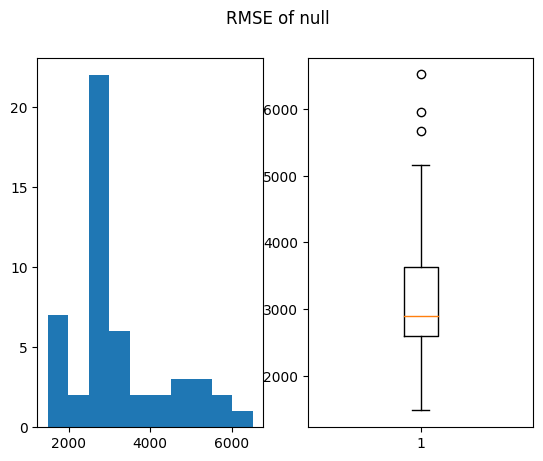

<Figure size 640x480 with 0 Axes>

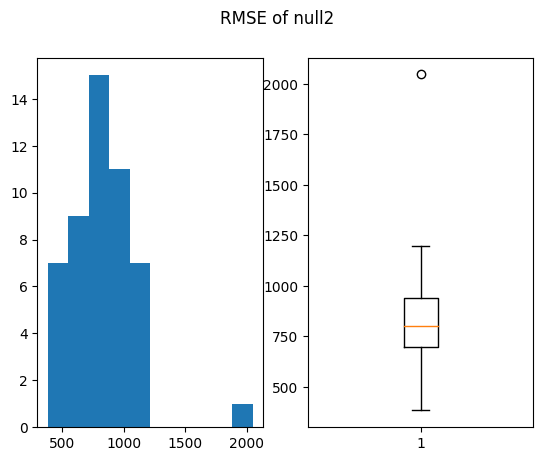

<Figure size 640x480 with 0 Axes>

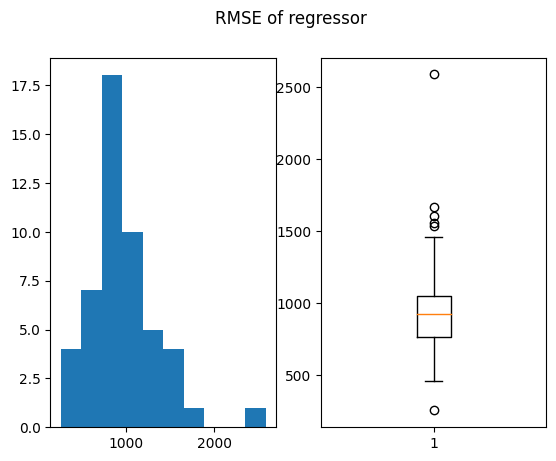

<Figure size 640x480 with 0 Axes>

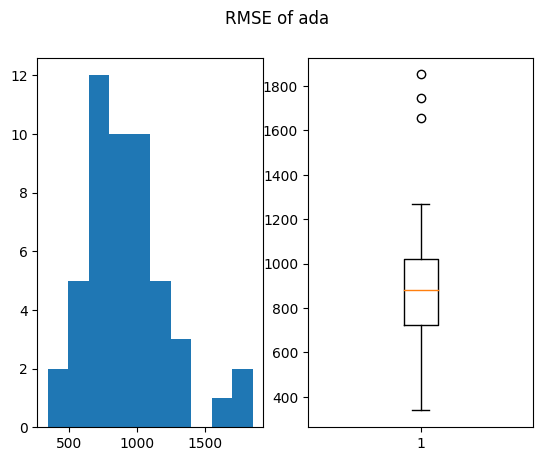

<Figure size 640x480 with 0 Axes>

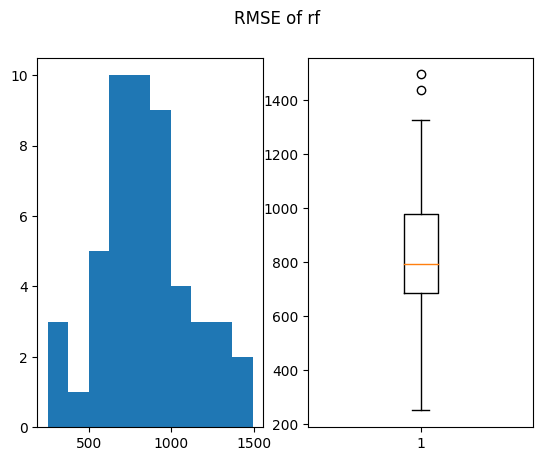

<Figure size 640x480 with 0 Axes>

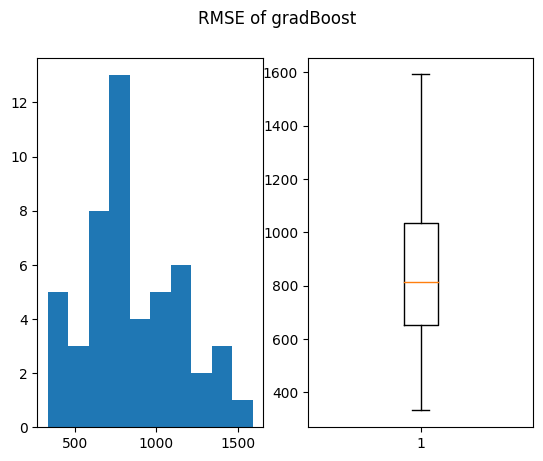

<Figure size 640x480 with 0 Axes>

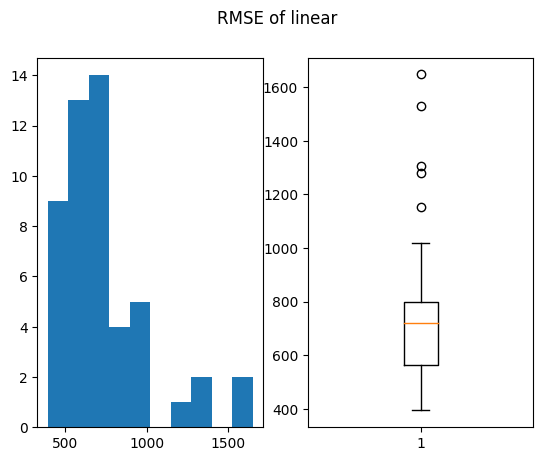

[ 2.88832158e-01 -4.51038981e-02 -1.90756632e-03  2.16949494e-03
 -1.74170241e-03 -3.88691568e+03  1.37637940e+03 -7.53292012e+02
 -1.22087706e+03 -4.79626232e+02 -1.25352514e+03 -1.02914778e+03
 -1.17763661e+03  3.91803111e+02 -1.45228509e+01 -2.08124057e+03
 -1.76674902e+03 -1.38708511e+03 -1.86090565e+03  1.13094203e+03
  9.80880446e+02  1.28055378e+03 -1.65633859e+03 -9.04573060e+02
  1.24276740e+02  2.00463707e+03 -2.23263185e+02  3.43398465e+03
 -1.23826689e+03  2.52089649e+03  1.54023750e+02 -5.91904291e+02
 -1.06658264e+03  6.01439161e+03 -2.94495503e+03 -2.91657648e+03
  1.44737463e+03 -8.82260850e+02  1.14519410e+04 -1.22277246e+03
 -2.09863538e+02  2.52041202e+03 -7.05542831e+02 -9.50519626e+02
 -5.57232280e+02 -2.15849287e+03 -1.30779570e+03  9.60072504e+02
  4.10120737e+03 -2.37942227e+03  3.99075888e+03 -3.18639432e+03
  1.51586233e+03 -2.63836103e+02  5.11674806e+02 -1.84153181e+03
 -1.96279309e+03 -1.59780236e+02 -2.12179968e+03  5.04845054e+03
 -2.59650161e+03]


In [23]:
# Try restricting the input to only the top 10 highest NMI attribute from communities
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_text

n = 50

nf_CV = KFold(n_splits=n, shuffle=True, random_state=42)
mses = {
    "null": [],
    "null2": []
}

relavantAttributes = []


for train_idx, test_idx in nf_CV.split(X):
    # train-test split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    y_null_predict = [y_train.mean()] * len(X_test)

    predicts = {}
    for name in models:
        model = models[name]
        models[name] = model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        predicts[name] = y_predict

    mse_null = mean_squared_error(y_test, y_null_predict)
    mses["null"].append(mse_null)

    modelTest = modelData.loc[X_test.index]
    mse_null_2 = mean_squared_error(modelTest["Rate per 100,000 population"], modelTest["Last Offence Rate1"])
    mses["null2"].append(mse_null_2)

    for name in models:
        mse = mean_squared_error(predicts[name], y_test)
        if name not in mses:
            mses[name] = []
        mses[name].append(mse)


    # if (np.sqrt(mse_ada) > 2000):
    #     print(X_test)
    #     print(y_test)

    # Get the summary of all attributes
    if "regressor" in models:
        tree_rules = export_text(models["regressor"], feature_names=list(X_train))
        relavantAttributes.extend(getSplitAttributes(tree_rules))
    

# Print the RMSE for each model
for key in mses:
    print("MSE of", key, ":", np.median(mses[key]))
    print("RMSE of", key, ":", np.median(np.sqrt(mses[key])))



print("Used attributes for regressor tree: ")
print(pd.Series(relavantAttributes).value_counts())



for name in mses:
    plt.figure()
    fig, axs = plt.subplots(1, 2)
    fig.suptitle("RMSE of " + name)
    axs[0].hist(np.sqrt(mses[name]))
    axs[1].boxplot(np.sqrt(mses[name]))
    plt.show()

print(models["linear"].coef_)

    